In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import numpy
import root_numpy
from hep_ml.nnet import MLPMultiClassifier
from rep.metaml import FoldingClassifier
from utils import shrink_floats

## Read the data

In [3]:
data = pandas.DataFrame(root_numpy.root2array('../data/global_train.root', 'tree'))
shrink_floats(data)

In [4]:
data_test = pandas.DataFrame(root_numpy.root2array('../data/global_test.root', 'tree'))
shrink_floats(data_test)

In [5]:
len(data)

5999993

In [6]:
data.head()

,VeloCharge,BremPIDe,CaloNeutralPrs,CaloNeutralSpd,InAccBrem,InAccSpd,CaloPrsE,InAccPrs,HcalPIDe,CaloHcalE,...,piplus_OWNPV_XERR,piplus_OWNPV_YERR,piplus_OWNPV_ZERR,piplus_OWNPV_CHI2,piplus_OWNPV_NDOF,piplus_IP_OWNPV,piplus_IPCHI2_OWNPV,nCandidate,totCandidates,EventInSequence
0,1.028090,-999,-999,-999,0,0,-999.000000,0,-999.000000,-999.000000,...,0.0096,0.0096,0.0532,33.816654,83,0.111340,15.622943,16,37,9099
1,1.044008,-999,-999,-999,0,0,-999.000000,0,-999.000000,-999.000000,...,0.0064,0.0063,0.0358,67.432457,187,0.025907,0.510528,38,106,12220
2,0.853933,-999,-999,-999,0,1,155.237808,1,-1.926180,27002.507812,...,0.0108,0.0108,0.0557,29.747982,67,0.136919,5.520920,14,76,8573
3,1.306180,-999,-999,-999,0,1,11.793685,1,0.434916,0.000000,...,0.0086,0.0084,0.0453,45.295311,97,0.572526,2.692502,25,50,13449
4,0.969101,-999,-999,-999,0,1,113.548508,1,1.788384,0.000000,...,0.0115,0.0110,0.0773,33.635342,71,0.101532,4.014179,24,86,1379


#### add signal column (from 0 to 5 classes), weights (to balance data), charges (to check assymetry)

In [7]:
from utils import compute_labels_and_weights, compute_charges, names_labels_correspondence, labels_names_correspondence
from utils import plot_hist_features, roc_auc_score_one_vs_all, compute_cum_sum, convert_DLL_to_LL
from utils import roc_auc_score_one_vs_all_for_separate_algorithms

In [8]:
data['Signal'], data['Weight'] = compute_labels_and_weights(data.MCParticleType.values)
data['Charge'] =  compute_charges(data.MCParticleType.values)

In [9]:
data_test['Signal'], data_test['Weight'] = compute_labels_and_weights(data_test.MCParticleType.values)
data_test['Charge'] =  compute_charges(data_test.MCParticleType.values)

#### check initial assymetry in data

In [10]:
print "positive tracks\t", numpy.mean(data.Charge > 0)
print "negative tracks\t", numpy.mean(data.Charge < 0)
print "GHOST tracks\t", numpy.mean(data.Charge == 0)

positive tracks	0.421249824791
negative tracks	0.412084147432
GHOST tracks	0.166666027777


In [11]:
print "positive tracks\t", numpy.mean(data_test.Charge > 0)
print "negative tracks\t", numpy.mean(data_test.Charge < 0)
print "GHOST tracks\t", numpy.mean(data_test.Charge == 0)

positive tracks	0.421374868958
negative tracks	0.411958519931
GHOST tracks	0.166666611111


#### weights

In [12]:
numpy.unique(data.Weight)

array([ 0.99989284,  0.99989484,  0.99989784,  0.99990384,  0.99990484,
        0.99990584])

#### number of tracks for each type

In [13]:
for key, val in names_labels_correspondence.items():
    print '{:10} \t'.format(key), sum(data.Signal == val)

Ghost      	999995
Electron   	1000004
Muon       	1000001
Pion       	1000006
Kaon       	999993
Proton     	999994


# Train, test splitting

In [11]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(data, train_size=0.51, random_state=19)

# Read features

In [14]:
import json
with open('./features.json', 'r') as f:
    features = json.load(f)
PV_features = features.pop('PV')

# Acceptance features

In [13]:
correlation = numpy.corrcoef(data[features['acceptance']].values.T)
print correlation

[[ 1.          0.97705683  0.10264026  0.87706855  0.73840696  0.72750569]
 [ 0.97705683  1.          0.10210573  0.87842376  0.73987679  0.72696906]
 [ 0.10264026  0.10210573  1.          0.15811423  0.08642432 -0.02202106]
 [ 0.87706855  0.87842376  0.15811423  1.          0.8152988   0.72163458]
 [ 0.73840696  0.73987679  0.08642432  0.8152988   1.          0.8042229 ]
 [ 0.72750569  0.72696906 -0.02202106  0.72163458  0.8042229   1.        ]]


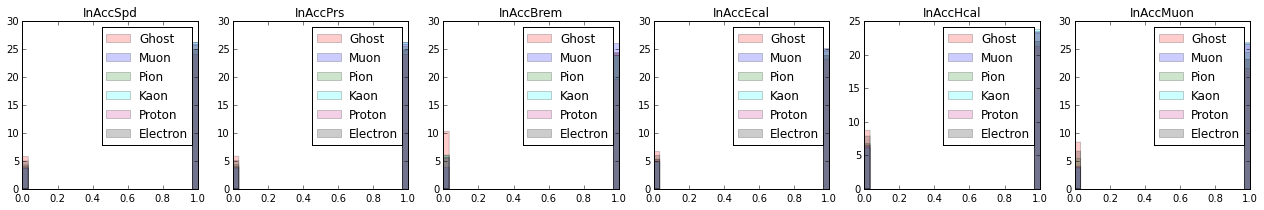

In [14]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features['acceptance'])

In [15]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal.values, train[f].values, train.Weight.values)
                    for f in features['acceptance']])
pd.index = features['acceptance']
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
InAccSpd,0.472598,0.514015,0.502434,0.513983,0.508670,0.488279
InAccPrs,0.472569,0.513843,0.502681,0.513956,0.508641,0.488290
InAccBrem,0.418980,0.547604,0.503779,0.505056,0.513728,0.510823
InAccEcal,0.476117,0.513016,0.503518,0.512305,0.505465,0.489558
InAccHcal,0.466945,0.512987,0.506027,0.519512,0.510554,0.483945
InAccMuon,0.439849,0.529775,0.499010,0.532587,0.526313,0.472435


### Cumulate sum for acceptance features

In [16]:
acceptance_cum_features = pandas.concat([compute_cum_sum(train, features['acceptance'], 'acc_to_right_'),
                                         compute_cum_sum(train, features['acceptance'][::-1], 'acc_to_left_')],
                                        axis=1)

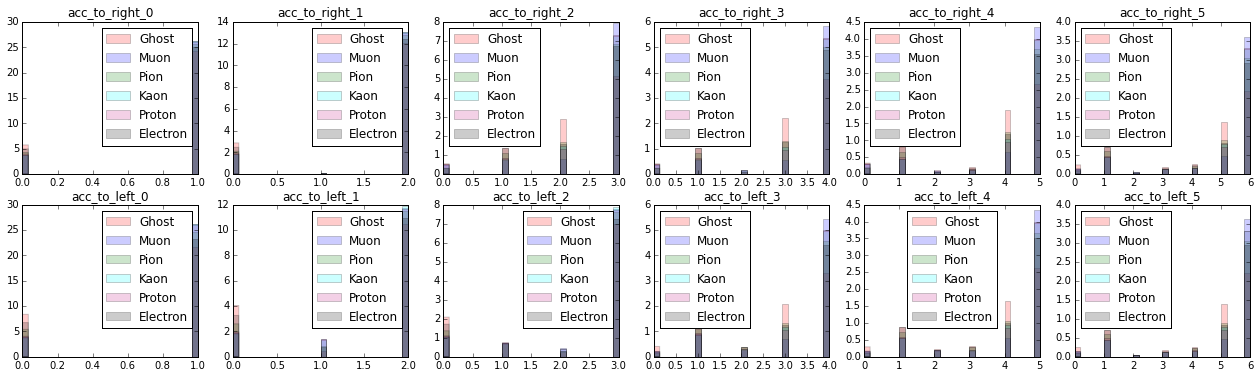

In [17]:
figure(figsize=(22, 6))
plot_hist_features(acceptance_cum_features, train.Signal, acceptance_cum_features.columns)

In [18]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal.values, acceptance_cum_features[f].values, 
                                             train.Weight.values) for f in acceptance_cum_features.columns])
pd.index = acceptance_cum_features.columns
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
acc_to_right_0,0.472598,0.514015,0.502434,0.513983,0.508670,0.488279
acc_to_right_1,0.473020,0.513784,0.502663,0.513719,0.508308,0.488485
acc_to_right_2,0.404647,0.558380,0.500736,0.521801,0.524377,0.490015
acc_to_right_3,0.405854,0.558229,0.500665,0.522522,0.524023,0.488664
acc_to_right_4,0.403838,0.557857,0.501116,0.526505,0.525942,0.484696
acc_to_right_5,0.400426,0.559414,0.499991,0.529901,0.528630,0.481591
acc_to_left_0,0.439849,0.529775,0.499010,0.532587,0.526313,0.472435
acc_to_left_1,0.456951,0.518542,0.504359,0.524839,0.515692,0.479585
acc_to_left_2,0.460111,0.518409,0.504147,0.522464,0.513348,0.481491
acc_to_left_3,0.399361,0.559394,0.500484,0.530103,0.528741,0.481869


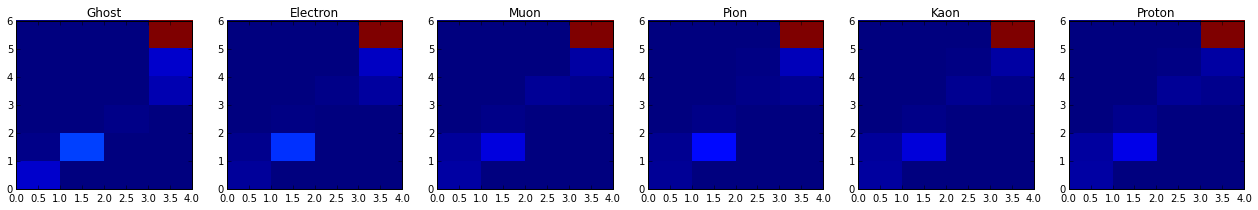

In [19]:
figure(figsize=(22, 3))
for key, val in names_labels_correspondence.items():
    subplot(1, 6, val+1)
    hist2d(acceptance_cum_features.loc[train.Signal.values == val, 'acc_to_right_3'].values, 
           acceptance_cum_features.loc[train.Signal.values == val, 'acc_to_right_5'].values,
           bins=(4, 6), normed=True, cmin=0, cmax=1,)
    title(key)

### use acceptance_to_right_3, acceptance_to_right_5

## NN on Acceptance

In [40]:
%%time
nn_acceptance = FoldingClassifier(MLPMultiClassifier(layers=(30, 10), scaler='iron', epochs=700), 
                                  features=features_acceptance, random_state=11, n_folds=2)
nn_acceptance.fit(train, train.Signal, train.Weight)

CPU times: user 1h 40min 42s, sys: 2h 2min 5s, total: 3h 42min 47s
Wall time: 53min 4s


In [21]:
roc_auc_score_one_vs_all(train.Signal.values, nn_acceptance.predict_proba(train), train.Weight.values)

KFold prediction using folds column


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.649895,0.594466,0.528653,0.551533,0.555891,0.545181


In [54]:
roc_auc_score_one_vs_all(test.Signal.values, nn_acceptance.predict_proba(test), test.Weight.values)

KFold prediction using random classifier (length of data passed not equal to length of train)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.650327,0.59419,0.52862,0.551242,0.557219,0.545242


In [42]:
import cPickle 
with open('models/nn_acceptance.pkl', 'w') as f:
    cPickle.dump(nn_acceptance, f)

In [20]:
import cPickle 
with open('models/nn_acceptance.pkl', 'r') as f:
    nn_acceptance = cPickle.load(f)

# CALO features

## PIDe

In [20]:
features_CALO_DLL_e = ['PrsPIDe', 'BremPIDe', 'EcalPIDe', 'HcalPIDe']

In [23]:
correlation = numpy.corrcoef(train[features_CALO_DLL_e].values.T)
print correlation

[[ 1.          0.10211602  0.87830461  0.73946844]
 [ 0.10211602  1.          0.15775566  0.08703819]
 [ 0.87830461  0.15775566  1.          0.81508783]
 [ 0.73946844  0.08703819  0.81508783  1.        ]]


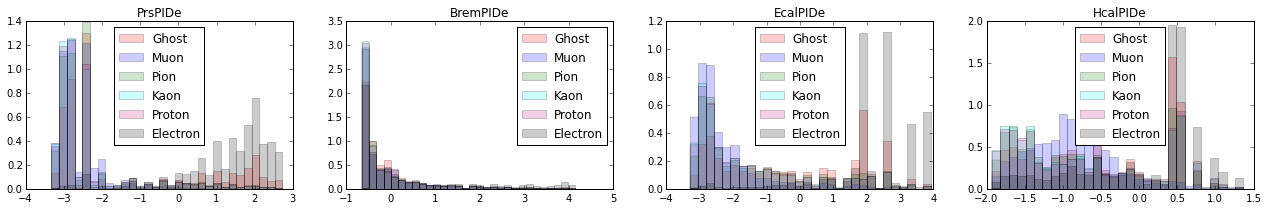

In [24]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features_CALO_DLL_e)

In [25]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_CALO_DLL_e])
pd.index = features_CALO_DLL_e
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
PrsPIDe,0.515698,0.407160,0.432509,0.420075,0.423449,0.801444
BremPIDe,0.443925,0.535061,0.480225,0.471949,0.485052,0.583846
EcalPIDe,0.537650,0.354793,0.457327,0.443919,0.439514,0.767102
HcalPIDe,0.481156,0.462492,0.471708,0.478970,0.480667,0.625147


In [26]:
CALO_LL_e_cum_features = compute_cum_sum(train, features_CALO_DLL_e, 'CALO_PID_e_to_right_')

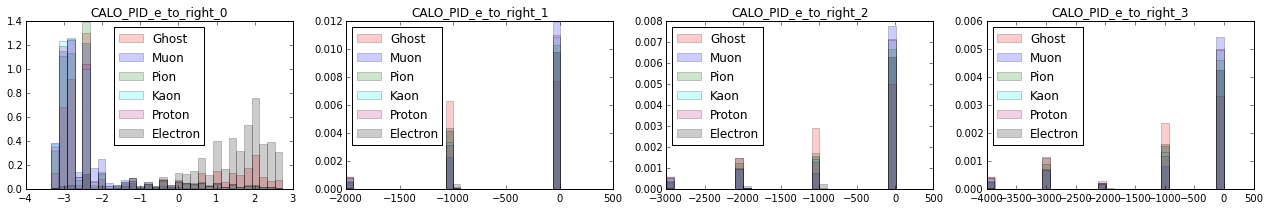

In [27]:
figure(figsize=(22, 3))
plot_hist_features(CALO_LL_e_cum_features, train.Signal, CALO_LL_e_cum_features.columns)

In [28]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, CALO_LL_e_cum_features[f], train.Weight) 
                    for f in CALO_LL_e_cum_features.columns])
pd.index = CALO_LL_e_cum_features.columns
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
CALO_PID_e_to_right_0,0.515698,0.407160,0.432509,0.420075,0.423449,0.801444
CALO_PID_e_to_right_1,0.418050,0.485787,0.449250,0.455653,0.466318,0.725161
CALO_PID_e_to_right_2,0.432739,0.448794,0.463806,0.469454,0.474895,0.710522
CALO_PID_e_to_right_3,0.430049,0.457872,0.468245,0.479801,0.484597,0.679616


## PIDmu

In [21]:
features_CALO_DLL_mu  = ['EcalPIDmu', 'HcalPIDmu']

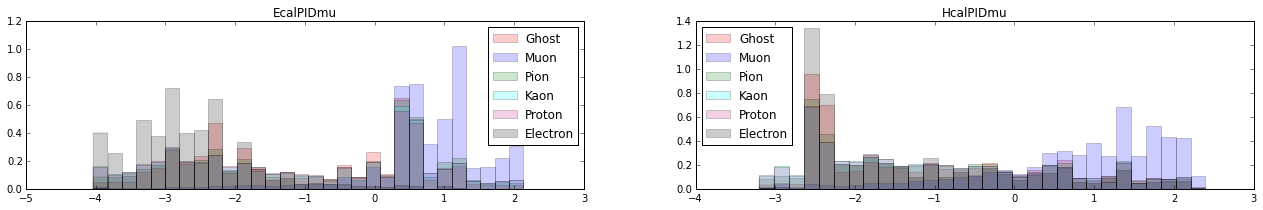

In [30]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features_CALO_DLL_mu)

In [31]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_CALO_DLL_mu])
pd.index = features_CALO_DLL_mu
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
EcalPIDmu,0.469975,0.757859,0.505364,0.496789,0.488642,0.281069
HcalPIDmu,0.437649,0.717301,0.475388,0.478760,0.470862,0.419890


In [32]:
roc_auc_score_one_vs_all(train.Signal, train.EcalPIDmu + train.HcalPIDmu, train.Weight)

,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.451969,0.767746,0.493877,0.491989,0.482565,0.311582


### use EcalPIDmu, HcalPIDmu, EcalPIDmu + HcalPIDmu

## energy

In [22]:
features_CALO_E = ['CaloSpdE', 'CaloPrsE', 'CaloEcalE', 'CaloHcalE']

In [34]:
correlation = numpy.corrcoef(train[features_CALO_E].values.T)
print correlation

[[ 1.          0.97371292  0.24201339  0.19971322]
 [ 0.97371292  1.          0.28704762  0.19320449]
 [ 0.24201339  0.28704762  1.          0.09783265]
 [ 0.19971322  0.19320449  0.09783265  1.        ]]


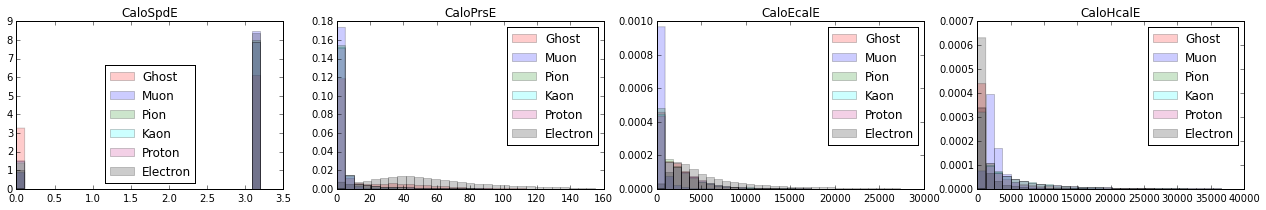

In [35]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features_CALO_E)

In [36]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_CALO_E])
pd.index = features_CALO_E
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
CaloSpdE,0.397673,0.547093,0.510505,0.518342,0.511633,0.514711
CaloPrsE,0.447293,0.420720,0.439918,0.450463,0.447577,0.794339
CaloEcalE,0.462691,0.313630,0.485794,0.512176,0.510942,0.715033
CaloHcalE,0.433090,0.587895,0.531196,0.562532,0.543224,0.341865


In [37]:
roc_auc_score_one_vs_all(train.Signal, train.CaloSpdE + train.CaloPrsE, train.Weight)

,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.436814,0.428465,0.44178,0.452663,0.449184,0.791395


### use energy separate, HcalPIDmu, CaloSpdE + CaloPrsE

## Neutral

In [23]:
features_CALO_neutral  = ['CaloNeutralSpd', 'CaloNeutralPrs', 'CaloNeutralEcal']

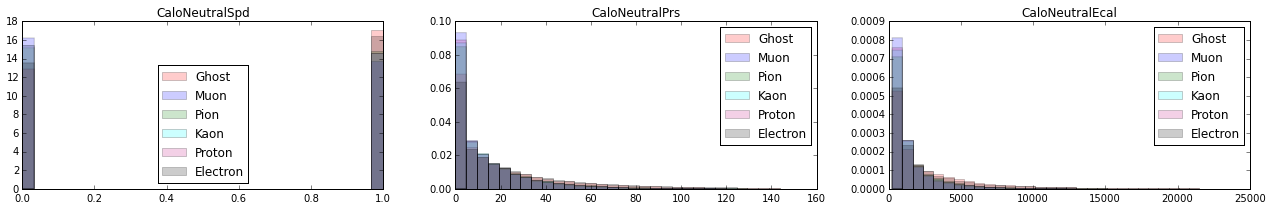

In [40]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal.values, features_CALO_neutral)

In [41]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_CALO_neutral])
pd.index = features_CALO_neutral
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
CaloNeutralSpd,0.439935,0.527173,0.499996,0.498185,0.507108,0.527602
CaloNeutralPrs,0.455727,0.506480,0.491394,0.484948,0.489148,0.572352
CaloNeutralEcal,0.476472,0.492683,0.492828,0.479788,0.483648,0.574637


In [42]:
roc_auc_score_one_vs_all(train.Signal, train.CaloNeutralSpd + train.InAccSpd, train.Weight)

,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.42053,0.540048,0.499497,0.50859,0.515232,0.516088


### Use CaloNeutralSpd + InAccSpd for Ghost

## Charged

In [24]:
features_CALO_charged = ['CaloChargedSpd', 'CaloChargedPrs' , 'CaloChargedEcal']

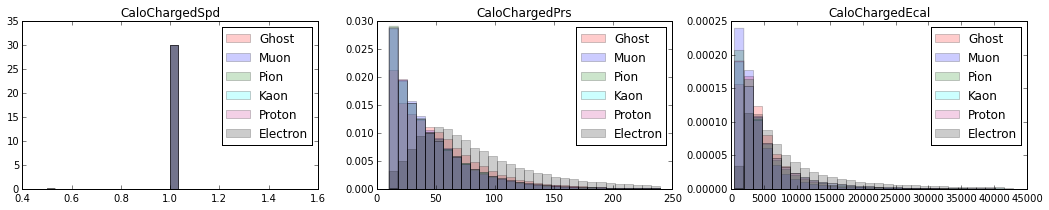

In [45]:
figure(figsize=(18, 3))
plot_hist_features(train, train.Signal, features_CALO_charged)

In [46]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_CALO_charged])
pd.index = features_CALO_charged
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
CaloChargedSpd,0.524456,0.398802,0.512335,0.505977,0.501543,0.556963
CaloChargedPrs,0.525733,0.368351,0.472989,0.470389,0.465802,0.696972
CaloChargedEcal,0.513556,0.353654,0.478197,0.490189,0.485470,0.679164


In [47]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, 
                                             train.CaloChargedSpd + train.CaloNeutralSpd + train.InAccSpd, 
                                             train.Weight),
                    roc_auc_score_one_vs_all(train.Signal, 
                                             train.CaloChargedSpd + train.CaloNeutralSpd, 
                                             train.Weight),
                    roc_auc_score_one_vs_all(train.Signal, 
                                             train.CaloChargedSpd + train.InAccSpd, 
                                             train.Weight),
                    roc_auc_score_one_vs_all(train.Signal, 
                                             train.CaloNeutralSpd + train.InAccSpd, 
                                             train.Weight)])
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.467340,0.440286,0.508629,0.511389,0.513527,0.558887
0,0.471969,0.430706,0.509522,0.508528,0.511950,0.567393
0,0.512644,0.417851,0.511257,0.509297,0.503918,0.545091
0,0.420530,0.540048,0.499497,0.508590,0.515232,0.516088


### use CaloNeutralSpd + InAccSpd for Ghost
### use CaloChargedSpd + InAccSpd for Muon
### use CaloNeutralSpd + CaloChargedSpd for Electron

## Others

In [25]:
features_CALO_others = ['CaloBremMatch', 'CaloElectronMatch', 'CaloTrMatch', 'CaloTrajectoryL']

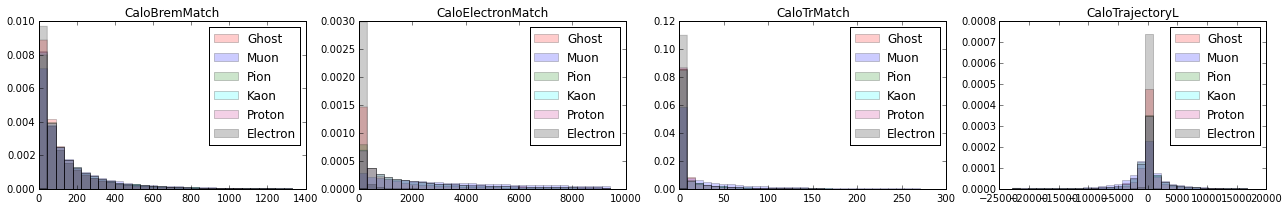

In [50]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features_CALO_others)

In [51]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_CALO_others])
pd.index = features_CALO_others
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
CaloBremMatch,0.402371,0.583346,0.511549,0.509998,0.516975,0.475676
CaloElectronMatch,0.487406,0.497626,0.559397,0.566520,0.561941,0.326919
CaloTrMatch,0.483529,0.674394,0.534036,0.526034,0.511261,0.270442
CaloTrajectoryL,0.536359,0.387319,0.505539,0.494970,0.488344,0.587578


## NN on CALO

In [52]:
print features['CALO']

[u'CaloBremMatch', u'CaloElectronMatch', u'CaloTrMatch', u'CaloTrajectoryL', u'CaloChargedSpd', u'CaloChargedPrs', u'CaloChargedEcal', u'CaloNeutralSpd', u'CaloNeutralPrs', u'CaloNeutralEcal', u'CaloSpdE', u'CaloPrsE', u'CaloEcalE', u'CaloHcalE', u'EcalPIDmu', u'HcalPIDmu', u'PrsPIDe', u'BremPIDe', u'EcalPIDe', u'HcalPIDe']


In [ ]:
%%time
nn_CALO = FoldingClassifier(MLPMultiClassifier(layers=(30, 10), scaler='iron', epochs=700), 
                            features=features['CALO'], random_state=13)
nn_CALO.fit(train, train.Signal, train.Weight)

In [59]:
roc_auc_score_one_vs_all(train.Signal.values, nn_CALO.predict_proba(train), train.Weight.values)

KFold prediction using folds column


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.782718,0.920485,0.711319,0.733464,0.737953,0.957749


In [60]:
roc_auc_score_one_vs_all(test.Signal.values, nn_CALO.predict_proba(test), test.Weight.values)

KFold prediction using random classifier (length of data passed not equal to length of train)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.783383,0.920655,0.710956,0.733835,0.738793,0.957806


In [61]:
import cPickle 
with open('models/nn_CALO.pkl', 'w') as f:
    cPickle.dump(nn_CALO, f)

In [62]:
# import cPickle 
# with open('models/nn_CALO.pkl', 'r') as f:
#     nn_CALO = cPickle.load(f)

# RICH features

## DLL

In [27]:
features_RICH_DLL = filter(lambda x: 'RichDLL' in x, train.columns)

In [64]:
features_RICH_DLL

['RichDLLbt', 'RichDLLpi', 'RichDLLe', 'RichDLLp', 'RichDLLmu', 'RichDLLk']

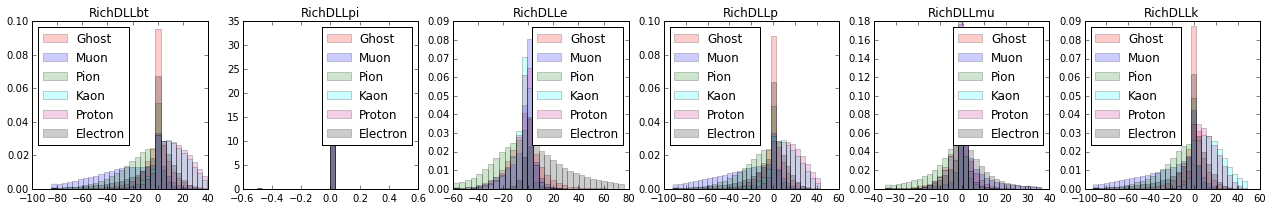

In [65]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features_RICH_DLL)

In [66]:
RICH_LL_features = convert_DLL_to_LL(train, list(set(features_RICH_DLL) - {'RichDLLbt'}))

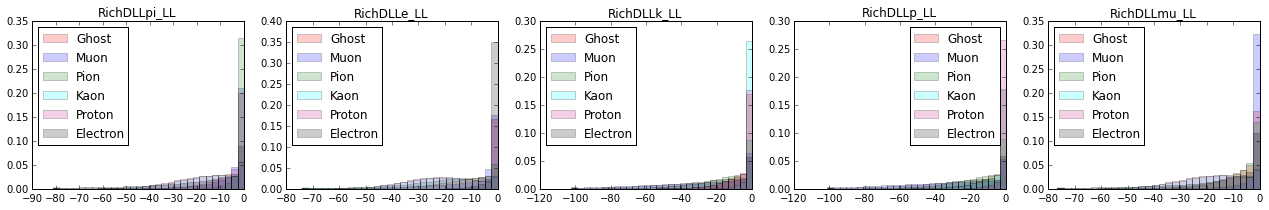

In [68]:
figure(figsize=(22, 3))
plot_hist_features(RICH_LL_features, train.Signal, RICH_LL_features.columns)

In [69]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_RICH_DLL])
pd.index = features_RICH_DLL
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
RichDLLbt,0.436394,0.244450,0.291215,0.762435,0.804872,0.461215
RichDLLpi,0.435293,0.520686,0.513707,0.519754,0.520301,0.490218
RichDLLe,0.423317,0.515585,0.239037,0.483031,0.491898,0.847782
RichDLLp,0.434866,0.239180,0.290739,0.752056,0.826160,0.457592
RichDLLmu,0.412700,0.704803,0.296376,0.461846,0.472952,0.651636
RichDLLk,0.426842,0.253148,0.277437,0.832366,0.759795,0.450974


In [70]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, RICH_LL_features[f], train.Weight) 
                    for f in RICH_LL_features.columns])
pd.index = RICH_LL_features.columns
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
RichDLLpi_LL,0.600339,0.611164,0.864339,0.303276,0.306764,0.313256
RichDLLe_LL,0.587186,0.560561,0.363761,0.286134,0.288636,0.914122
RichDLLk_LL,0.565481,0.261342,0.385300,0.879307,0.643460,0.265322
RichDLLp_LL,0.576632,0.236128,0.397880,0.637899,0.877936,0.273871
RichDLLmu_LL,0.585285,0.857602,0.553441,0.293666,0.296155,0.413442


### Use DLL and LL

## Gas

In [28]:
features_RICH_gas = ['RichUsedR1Gas', 'RichUsedR2Gas']

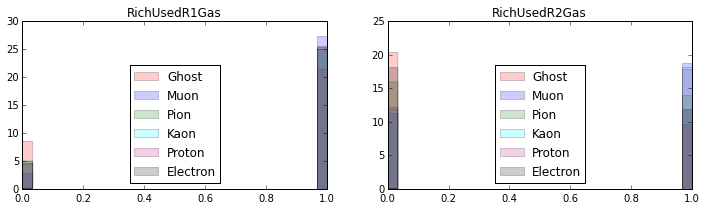

In [73]:
figure(figsize=(12, 3))
plot_hist_features(train, train.Signal, features_RICH_gas)

In [74]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_RICH_gas])
pd.index = features_RICH_gas
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
RichUsedR1Gas,0.430440,0.546558,0.500557,0.502822,0.511228,0.508370
RichUsedR2Gas,0.391492,0.573644,0.479339,0.562783,0.556237,0.436464


In [75]:
roc_auc_score_one_vs_all(train.Signal, train.RichUsedR1Gas + train.RichUsedR2Gas, train.Weight)

,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.352224,0.607458,0.476277,0.555814,0.5574,0.450779


### use RichUsedR1Gas, RichUsedR2Gas, RichUsedR1Gas + RichUsedR2Gas

## Above

In [29]:
features_RICH_above = filter(lambda x: 'RichAbove' in x, train.columns)

In [77]:
print features_RICH_above

['RichAboveMuThres', 'RichAboveElThres', 'RichAbovePiThres', 'RichAboveKaThres', 'RichAbovePrThres']


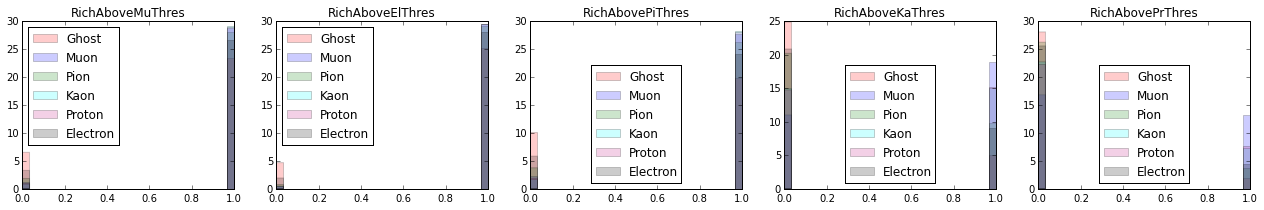

In [79]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features_RICH_above)

In [80]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features_RICH_above])
pd.index = features_RICH_above
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
RichAboveMuThres,0.417862,0.525917,0.511579,0.531892,0.530073,0.482632
RichAboveElThres,0.435293,0.520686,0.513707,0.519754,0.520301,0.490218
RichAbovePiThres,0.383267,0.540818,0.509421,0.551447,0.547237,0.467753
RichAboveKaThres,0.357849,0.635367,0.451112,0.556771,0.560593,0.438283
RichAbovePrThres,0.410654,0.635965,0.447405,0.517854,0.527376,0.460735


In [81]:
roc_auc_score_one_vs_all(train.Signal, train.RichAboveKaThres + train.RichAbovePrThres + \
                         train.RichAboveElThres + train.RichAbovePiThres, train.Weight)

,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.298957,0.668037,0.454049,0.574808,0.578938,0.425153


In [83]:
roc_auc_score_one_vs_all(train.Signal, train.RichAbovePiThres + train.RichAboveKaThres + \
                         train.RichAboveElThres + train.RichAboveMuThres, train.Weight)

,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.30527,0.641232,0.465031,0.579664,0.580665,0.42808


In [84]:
roc_auc_score_one_vs_all(train.Signal, train.RichAboveKaThres + train.RichAbovePrThres, train.Weight)

,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.351616,0.662001,0.440072,0.552008,0.558894,0.435384


### Use Above, Pion + Kaon + Electron + Muon, Kaon + Proton

## NN on RICH features

In [85]:
print features['RICH']

[u'RichAboveMuThres', u'RichAboveElThres', u'RichAbovePiThres', u'RichAboveKaThres', u'RichAbovePrThres', u'RichUsedR1Gas', u'RichUsedR2Gas', u'RichDLLbt', u'RichDLLpi', u'RichDLLe', u'RichDLLp', u'RichDLLmu', u'RichDLLk']


In [86]:
%%time
nn_RICH = FoldingClassifier(MLPMultiClassifier(layers=(30, 10), scaler='iron', epochs=700), 
                            features=features['RICH'], random_state=17)
nn_RICH.fit(train, train.Signal, train.Weight)

CPU times: user 1h 54min 39s, sys: 1h 57min 31s, total: 3h 52min 11s
Wall time: 56min 39s


In [87]:
roc_auc_score_one_vs_all(train.Signal.values, nn_RICH.predict_proba(train), train.Weight.values)

KFold prediction using folds column


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.791677,0.908993,0.889137,0.890229,0.887869,0.922159


In [88]:
roc_auc_score_one_vs_all(test.Signal.values, nn_RICH.predict_proba(test), test.Weight.values)

KFold prediction using random classifier (length of data passed not equal to length of train)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.791443,0.908899,0.888723,0.889439,0.887571,0.922008


In [89]:
import cPickle 
with open('models/nn_RICH.pkl', 'w') as f:
    cPickle.dump(nn_RICH, f)

In [28]:
# import cPickle 
# with open('models/nn_RICH.pkl', 'r') as f:
#     nn_RICH = cPickle.load(f)

# Comb DLL

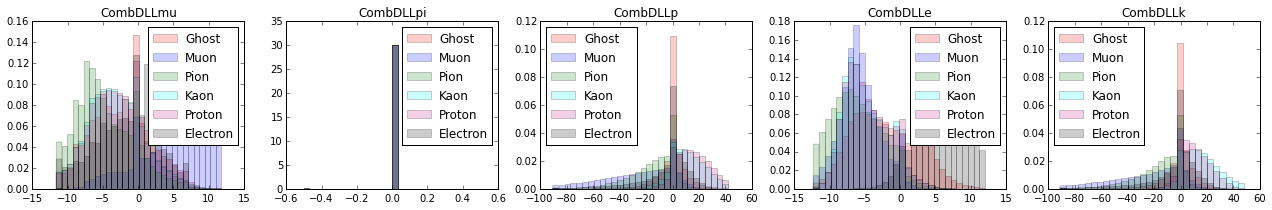

In [93]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features['DLL'])

In [94]:
comb_LL_features = convert_DLL_to_LL(train, features['DLL'])

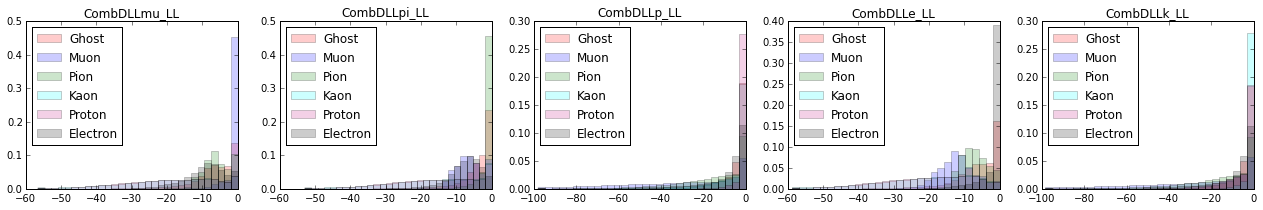

In [95]:
figure(figsize=(22, 3))
plot_hist_features(comb_LL_features, train.Signal, comb_LL_features.columns)

In [96]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features['DLL']])
pd.index = features['DLL']
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
CombDLLmu,0.450773,0.903131,0.287599,0.407823,0.413989,0.536812
CombDLLpi,0.488203,0.502843,0.503812,0.502393,0.502123,0.500618
CombDLLp,0.486451,0.207145,0.266926,0.748201,0.825075,0.466865
CombDLLe,0.559540,0.345298,0.299322,0.410885,0.421735,0.963927
CombDLLk,0.477358,0.221627,0.253222,0.832272,0.756548,0.459606


In [97]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, comb_LL_features[f], train.Weight) 
                    for f in comb_LL_features.columns])
pd.index = comb_LL_features.columns
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
CombDLLmu_LL,0.575887,0.940830,0.579574,0.228199,0.228611,0.446395
CombDLLpi_LL,0.656667,0.485916,0.900296,0.262667,0.262794,0.430871
CombDLLp_LL,0.561777,0.197712,0.345302,0.605507,0.868822,0.421430
CombDLLe_LL,0.659885,0.379678,0.584466,0.228378,0.230034,0.917671
CombDLLk_LL,0.553149,0.212593,0.334615,0.872073,0.611043,0.416934


## NN on COMB_DLL

In [98]:
%%time
nn_COMBO = FoldingClassifier(MLPMultiClassifier(layers=(30, 10), scaler='iron', epochs=700), 
                             features=features_Comb_DLL, random_state=19)
nn_COMBO.fit(train, train.Signal, train.Weight)

CPU times: user 1h 45min 12s, sys: 1h 58min 5s, total: 3h 43min 17s
Wall time: 52min 55s


In [99]:
roc_auc_score_one_vs_all(train.Signal.values, nn_COMBO.predict_proba(train), train.Weight.values)

KFold prediction using folds column


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.777172,0.960589,0.91529,0.897594,0.891551,0.97604


In [100]:
roc_auc_score_one_vs_all(test.Signal.values, nn_COMBO.predict_proba(test), test.Weight.values)

KFold prediction using random classifier (length of data passed not equal to length of train)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.776957,0.960344,0.915085,0.896799,0.891316,0.975851


In [101]:
import cPickle 
with open('models/nn_COMBO.pkl', 'w') as f:
    cPickle.dump(nn_COMBO, f)

In [30]:
# import cPickle 
# with open('models/nn_COMBO.pkl', 'r') as f:
#     nn_COMBO = cPickle.load(f)

## Track features

In [102]:
print features['track']

[u'TrackFitVeloChi2', u'TrackFitVeloNDoF', u'TrackFitMatchChi2', u'TrackGhostProbability', u'TrackP', u'TrackChi2PerDof', u'TrackFitTChi2', u'TrackPt', u'TrackNumDof', u'TrackFitTNDoF', u'TrackDOCA']


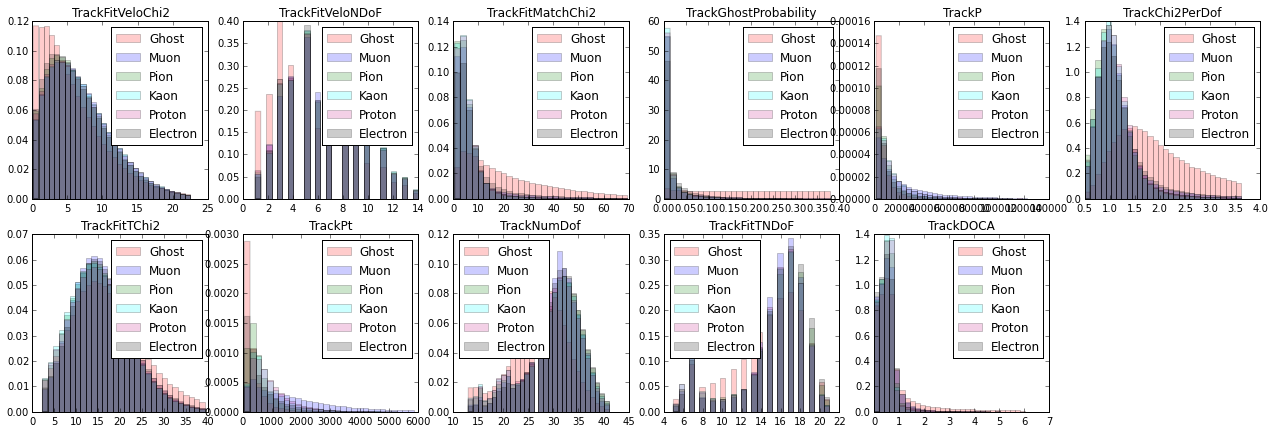

In [ ]:
figure(figsize=(22, 7))
plot_hist_features(train, train.Signal, features['track'])

In [104]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features['track']])
pd.index = features['track']
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
TrackFitVeloChi2,0.424208,0.524575,0.505828,0.526372,0.519255,0.499736
TrackFitVeloNDoF,0.374783,0.526722,0.524397,0.531786,0.516210,0.526051
TrackFitMatchChi2,0.813502,0.455804,0.411510,0.405706,0.415983,0.497678
TrackGhostProbability,0.931192,0.400108,0.409511,0.380910,0.397401,0.481092
TrackP,0.309878,0.667569,0.447196,0.582335,0.580835,0.412134
TrackChi2PerDof,0.824594,0.454934,0.405621,0.417230,0.439001,0.458799
TrackFitTChi2,0.548570,0.495915,0.479334,0.472946,0.491974,0.511310
TrackPt,0.206844,0.754960,0.428455,0.579304,0.603260,0.427116
TrackNumDof,0.337311,0.535696,0.536516,0.520279,0.509633,0.560505
TrackFitTNDoF,0.446766,0.510447,0.519609,0.483283,0.482237,0.557643


In [ ]:
%%time
nn_track = FoldingClassifier(MLPMultiClassifier(layers=(30, 10), scaler='iron', epochs=700), 
                             features=features['track'], random_state=21)
nn_track.fit(train, train.Signal, train.Weight)

In [110]:
roc_auc_score_one_vs_all(train.Signal.values, nn_track.predict_proba(train), train.Weight.values)

KFold prediction using folds column


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.949269,0.794906,0.713765,0.692246,0.689498,0.674875


In [111]:
roc_auc_score_one_vs_all(test.Signal.values, nn_track.predict_proba(test), test.Weight.values)

KFold prediction using random classifier (length of data passed not equal to length of train)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.949102,0.793697,0.713196,0.691628,0.6887,0.674521


In [112]:
import cPickle 
with open('models/nn_track.pkl', 'w') as f:
    cPickle.dump(nn_track, f)

In [113]:
# import cPickle 
# with open('models/nn_track.pkl', 'r') as f:
#     nn_track = cPickle.load(f)

# Muon features

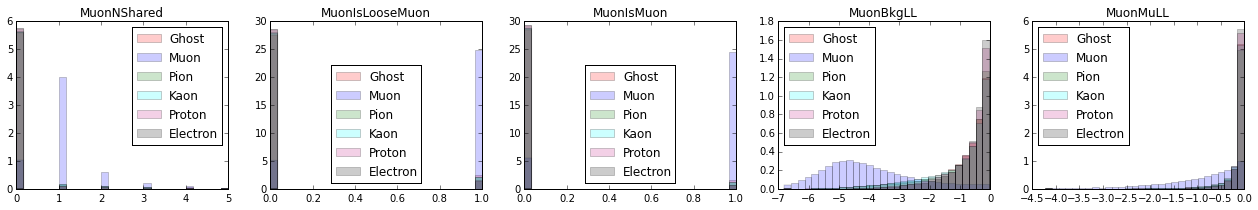

In [114]:
figure(figsize=(22, 3))
plot_hist_features(train, train.Signal, features['muon'])

In [115]:
pd = pandas.concat([roc_auc_score_one_vs_all(train.Signal, train[f], train.Weight) 
                    for f in features['muon']])
pd.index = features['muon']
pd

,Ghost,Muon,Pion,Kaon,Proton,Electron
MuonNShared,0.438636,0.870277,0.430001,0.427726,0.416977,0.416205
MuonIsLooseMuon,0.434131,0.883389,0.427430,0.425795,0.415090,0.413982
MuonIsMuon,0.429880,0.889591,0.425703,0.424398,0.415049,0.415194
MuonBkgLL,0.439854,0.860285,0.432357,0.430385,0.419042,0.417903
MuonMuLL,0.439190,0.863267,0.431482,0.429913,0.418544,0.417428


In [117]:
%%time
nn_muon = FoldingClassifier(MLPMultiClassifier(layers=(30, 10), scaler='iron', epochs=700), 
                            features=features['muon'], random_state=29)
nn_muon.fit(train, train.Signal, train.Weight)

CPU times: user 1h 36min 13s, sys: 1h 55min 40s, total: 3h 31min 54s
Wall time: 51min 49s


In [118]:
roc_auc_score_one_vs_all(train.Signal.values, nn_muon.predict_proba(train), train.Weight.values)

KFold prediction using folds column


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.583654,0.908738,0.578513,0.580543,0.588797,0.589712


In [119]:
roc_auc_score_one_vs_all(test.Signal.values, nn_muon.predict_proba(test), test.Weight.values)

KFold prediction using random classifier (length of data passed not equal to length of train)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.58367,0.908846,0.578334,0.581427,0.588845,0.589553


In [92]:
roc_auc_score_one_vs_all(test.Signal.values, nn_muon.predict_proba(test), test.Weight.values)

KFold prediction using folds column


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.581969,0.901451,0.576673,0.578904,0.588895,0.588532


In [120]:
import cPickle 
with open('models/nn_muon.pkl', 'w') as f:
    cPickle.dump(nn_muon, f)

In [ ]:
# import cPickle 
# with open('models/nn_muon.pkl', 'r') as f:
#     nn_muon = cPickle.load(f)

# Prepare data from NN predictions

In [121]:
nn_outputs = []
nn_outputs_test = []
for nn, name in zip([nn_acceptance, nn_CALO, nn_RICH, nn_COMBO, nn_track, nn_muon], 
                    ['acceptance', 'calo', 'rich', 'combo', 'track', 'muon']):
    nn_outputs.append(pandas.DataFrame(nn.predict_proba(train), columns=[name + '_' + str(i) for i in range(6)]))
    nn_outputs_test.append(pandas.DataFrame(nn.predict_proba(test), columns=[name + '_' + str(i) for i in range(6)]))
data_train_nn = pandas.concat(nn_outputs, axis=1)
data_test_nn = pandas.concat(nn_outputs_test, axis=1)

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


In [149]:
nn_outputs_temp = []
for nn, name in zip([nn_acceptance, nn_CALO, nn_RICH, nn_COMBO, nn_track, nn_muon], 
                    ['acceptance', 'calo', 'rich', 'combo', 'track', 'muon']):
    nn_outputs_temp.append(pandas.DataFrame(nn.predict_proba(data_test), 
                                            columns=[name + '_' + str(i) for i in range(6)]))
data_test_nn_all = pandas.concat(nn_outputs_temp, axis=1)

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


# NN on NNs from subsystems

In [123]:
%%time
nn_subsystems = MLPMultiClassifier(layers=(30, 10), scaler='iron', epochs=700)
nn_subsystems.fit(data_train_nn, train.Signal, train.Weight)

CPU times: user 2h 36min 49s, sys: 1h 49min 15s, total: 4h 26min 4s
Wall time: 58min 17s


In [166]:
roc_auc_score_one_vs_all(test.Signal.values, nn_subsystems.predict_proba(data_test_nn), test.Weight.values)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.956819,0.988232,0.990364,0.951709,0.923852,0.922669


In [167]:
roc_auc_score_one_vs_all(data_test.Signal.values, nn_subsystems.predict_proba(data_test_nn_all), data_test.Weight.values)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.956857,0.988102,0.989989,0.951694,0.924102,0.922618


In [125]:
import cPickle 
with open('models/nn_subsystems.pkl', 'w') as f:
    cPickle.dump(nn_subsystems, f)

# NN on original features and subsystems features

In [126]:
features_all_and_subsystems = list(data_train_nn.columns) + list(numpy.concatenate(features.values()))

In [127]:
train.index = range(len(train))
test.index = range(len(test))

In [253]:
data_train_extended = pandas.concat([train, data_train_nn], axis=1)
data_test_extended = pandas.concat([test, data_test_nn], axis=1)

In [254]:
data_test_all_extended = pandas.concat([data_test, data_test_nn_all], axis=1)

In [129]:
%%time
nn_add_subsystems = FoldingClassifier(MLPMultiClassifier(layers=(40, 20), scaler='iron', epochs=1000), 
                                      features=features_all_and_subsystems, random_state=31)
nn_add_subsystems.fit(data_train_extended, data_train_extended.Signal, data_train_extended.Weight)

CPU times: user 6h 49min 12s, sys: 4h 9min 6s, total: 10h 58min 19s
Wall time: 2h 16min 46s


In [130]:
import cPickle 
with open('models/nn_add_subsystems.pkl', 'w') as f:
    cPickle.dump(nn_add_subsystems, f)

In [168]:
roc_auc_score_one_vs_all(data_test_extended.Signal.values, nn_add_subsystems.predict_proba(data_test_extended), 
                         data_test_extended.Weight.values)

KFold prediction using random classifier (length of data passed not equal to length of train)


,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.959406,0.989826,0.991818,0.954768,0.927002,0.927121


In [169]:
roc_auc_score_one_vs_all(data_test_all_extended.Signal.values, nn_add_subsystems.predict_proba(data_test_all_extended), 
                         data_test_all_extended.Weight.values)

KFold prediction using random classifier (length of data passed not equal to length of train)


,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.959411,0.989753,0.9915,0.954803,0.927248,0.927084


# DT on original features

In [15]:
features_original = concatenate(features.values())

In [16]:
len(features_original)

60

In [17]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier

In [138]:
with open('log', 'w') as f:
    f.write("DT training starts\n")

In [ ]:
%%time
dt_one_vs_all = dict()
for label in names_labels_correspondence.values():
    dt_temp = SklearnClassifier(DecisionTrainClassifier(n_estimators=40000, depth=7, learning_rate=0.1, n_threads=12), 
                                features=features_original)
    dt_one_vs_all[label] = dt_temp.fit(train, train.Signal.values == label)
    with open('models/dt.pkl', 'w') as f:
        cPickle.dump(dt_one_vs_all, f)
    with open('log', 'a') as f:
        f.write("{} is trained\n".format(label))

In [143]:
from sklearn.metrics import roc_auc_score

In [174]:
preds = {}
for label, cl in dt_one_vs_all.items():
    preds[label] = cl.predict_proba(test)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(test.Signal.values, preds, sample_weight=test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.962956,0.991086,0.992695,0.956789,0.928868,0.929149


In [175]:
preds = {}
for label, cl in dt_one_vs_all.items():
    preds[label] = cl.predict_proba(data_test)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds, sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.962971,0.991057,0.992419,0.956788,0.929119,0.929098


In [145]:
from rep.report.metrics import RocAuc

reports = dict()
for label, cl in dt_one_vs_all.items():
    reports[label] = cl.test_on(test, test.Signal.values == label, sample_weight=test.Weight)

lcs = dict()
for key, value in reports.items():
    lcs[key] = value.learning_curve(RocAuc(), steps=20)

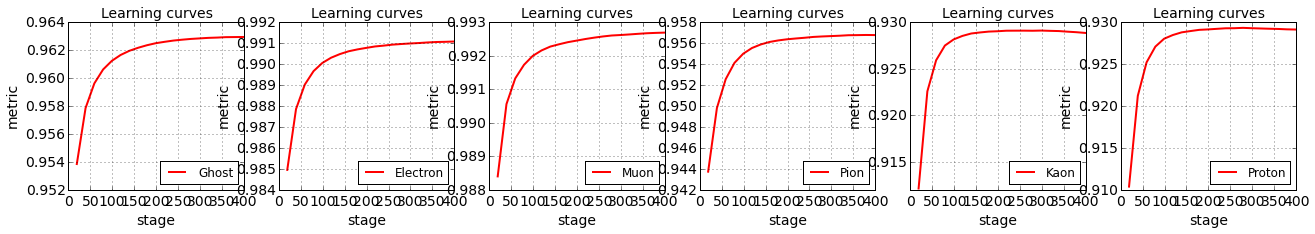

In [147]:
figure(figsize=(22, 3))
for key, value in lcs.items():
    subplot(1, 6, key + 1)
    value.plot()
    legend([labels_names_correspondence[key]], loc='best')

In [210]:
a=dt_one_vs_all[5].get_feature_importances()
a.sort(columns='effect', ascending=False)[:15]

/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,effect
TrackP,0.058500
CombDLLk,0.056500
CombDLLp,0.054925
TrackPt,0.052250
RichDLLe,0.051550
CombDLLe,0.043750
TrackGhostProbability,0.042875
RichDLLbt,0.035300
RichDLLmu,0.034150
CombDLLmu,0.031050


---------------------------------------

# DT on original features and NNs features from subsystems

In [177]:
with open('log', 'w') as f:
    f.write("DT training starts \n")

In [178]:
%%time
dt_extended_one_vs_all = dict()
for label in names_labels_correspondence.values():
    dt_temp = SklearnClassifier(DecisionTrainClassifier(n_estimators=40000, depth=7, learning_rate=0.1, n_threads=12), 
                                features=features_all_and_subsystems)
    dt_extended_one_vs_all[label] = dt_temp.fit(data_train_extended, data_train_extended.Signal.values == label)
    with open('models/dt_add_subsystems.pkl', 'w') as f:
        cPickle.dump(dt_extended_one_vs_all, f)
    with open('log', 'a') as f:
        f.write("{} is trained\n".format(label))

CPU times: user 1d 17h 48min 4s, sys: 2min 24s, total: 1d 17h 50min 28s
Wall time: 4h 13min 38s


In [179]:
preds = {}
for label, cl in dt_extended_one_vs_all.items():
    preds[label] = cl.predict_proba(data_test_extended)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(data_test_extended.Signal.values, preds, 
                                                 sample_weight=data_test_extended.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.962626,0.991008,0.992709,0.956732,0.929129,0.929436


In [182]:
preds = {}
for label, cl in dt_extended_one_vs_all.items():
    preds[label] = cl.predict_proba(data_test_all_extended)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(data_test_all_extended.Signal.values, preds, 
                                                 sample_weight=data_test_all_extended.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.962664,0.990968,0.992449,0.956737,0.929262,0.929271


In [183]:
reports = dict()
for label, cl in dt_one_vs_all.items():
    reports[label] = cl.test_on(test, test.Signal.values == label, sample_weight=test.Weight)

lcs = dict()
for key, value in reports.items():
    lcs[key] = value.learning_curve(RocAuc(), steps=20)

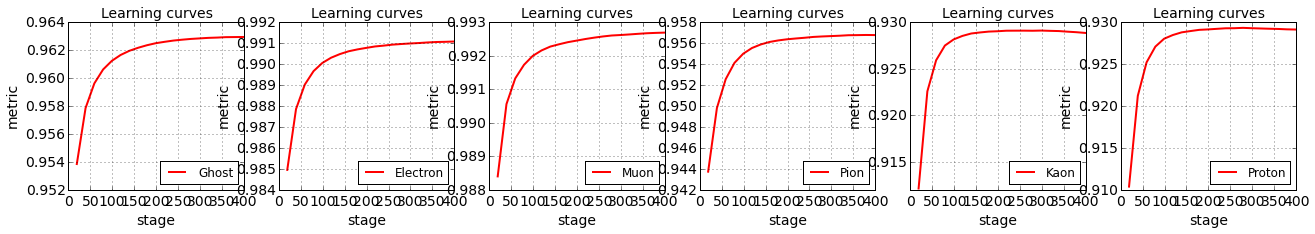

In [184]:
figure(figsize=(22, 3))
for key, value in lcs.items():
    subplot(1, 6, key + 1)
    value.plot()
    legend([labels_names_correspondence[key]], loc='best')

In [215]:
a=dt_extended_one_vs_all[5].get_feature_importances()
a.sort(columns='effect', ascending=False)[:15]

/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,effect
rich_5,0.067275
combo_5,0.063150
combo_4,0.044250
rich_4,0.041900
TrackP,0.041625
track_3,0.036250
calo_3,0.028350
rich_0,0.021500
TrackDOCA,0.019775
track_0,0.018925


# Add constructed features; DT on 
* original features +
* constructed features

In [53]:
def add_constructed_features(data):
    added_features = []
    data_comb = convert_DLL_to_LL(data, features['DLL'])
    data_rich = convert_DLL_to_LL(data, list(set(features_RICH_DLL) - {'RichDLLbt'}))
    data_acceptance = compute_cum_sum(data, features['acceptance'], prefix_name='acc_cum_sum_')
    added_features = list(data_comb.columns) + list(data_rich.columns) + ['acc_cum_sum_3', 'acc_cum_sum_5']
    
    data = pandas.concat([data, data_rich, data_comb, data_acceptance[added_features[-2:]]], axis=1)
    
    data['RichAboveSumPiKaElMuTHres'] = data.RichAbovePiThres + data.RichAboveKaThres + \
        data.RichAboveElThres + data.RichAboveMuThres
    data['RichAboveSumKaPrTHres'] = data.RichAboveKaThres + data.RichAbovePrThres
    data['RichUsedGas'] = data.RichUsedR1Gas + data.RichUsedR2Gas
    data['SpdCaloNeutralAcc'] = data.CaloNeutralSpd + data.InAccSpd # for ghost
    data['SpdCaloChargedAcc'] = data.CaloChargedSpd + data.InAccSpd # for muon
    data['SpdCaloChargedNeutral'] = data.CaloChargedSpd + data.CaloNeutralSpd # for electron
    data['CaloSumSpdPrsE'] = data.CaloSpdE + data.CaloPrsE 
    data['CaloSumPIDmu'] = data.EcalPIDmu + data.HcalPIDmu 
    added_features = added_features + ['RichAboveSumPiKaElMuTHres', 'RichAboveSumKaPrTHres', 'RichUsedGas', 
                                       'SpdCaloNeutralAcc', 'SpdCaloChargedAcc', 'SpdCaloChargedNeutral', 
                                       'CaloSumSpdPrsE', 'CaloSumPIDmu']
    return data, added_features

In [260]:
data_train_extended, features_constructed = add_constructed_features(data_train_extended)
data_test_extended, _ = add_constructed_features(data_test_extended)
data_test_all_extended, _ = add_constructed_features(data_test_all_extended)

In [269]:
with open('log', 'w') as f:
    f.write("DT training starts \n")
dt_full_one_vs_all = dict()
for label in names_labels_correspondence.values():
    dt_temp = SklearnClassifier(DecisionTrainClassifier(n_estimators=40000, depth=7, learning_rate=0.1, n_threads=12), 
                                features=list(features_original) + features_constructed)
    dt_full_one_vs_all[label] = dt_temp.fit(data_train_extended, data_train_extended.Signal.values == label)
    with open('models/dt_constructed.pkl', 'w') as f:
        cPickle.dump(dt_full_one_vs_all, f)
    with open('log', 'a') as f:
        f.write("{} is trained\n".format(label))

In [270]:
preds = {}
for label, cl in dt_full_one_vs_all.items():
    preds[label] = cl.predict_proba(data_test_extended)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(data_test_extended.Signal.values, preds, 
                                                 sample_weight=data_test_extended.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.96299,0.991129,0.992785,0.956843,0.929649,0.929959


In [291]:
preds = {}
for label, cl in dt_full_one_vs_all.items():
    preds[label] = cl.predict_proba(data_test_all_extended)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(data_test_all_extended.Signal.values, preds, 
                                                 sample_weight=data_test_all_extended.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.963012,0.991084,0.992521,0.956809,0.929811,0.929844


In [275]:
preds_norm = {}
for label, cl in dt_full_one_vs_all.items():
    preds_norm[label] = preds[label] / numpy.sum(preds.values(), axis=0)

In [277]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test_all_extended.Signal.values, preds_norm, 
                                                 sample_weight=data_test_all_extended.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.961528,0.990651,0.9924,0.956599,0.929661,0.92938


In [294]:
nn_pred = nn_add_subsystems.predict_proba(data_test_all_extended)
for label, cl in dt_full_one_vs_all.items():
    nn_pred[:, label] *= 0.2
    nn_pred[:, label] += 0.8 * preds[label]

KFold prediction using random classifier (length of data passed not equal to length of train)


In [295]:
roc_auc_score_one_vs_all(data_test_all_extended.Signal.values, nn_pred, sample_weight=data_test_all_extended.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.963028,0.991111,0.992536,0.957152,0.930404,0.930469


In [290]:
roc_auc_score_one_vs_all(data_test_all_extended.Signal.values, nn_pred, sample_weight=data_test_all_extended.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.962041,0.990768,0.992371,0.957104,0.930143,0.930061


In [283]:
numpy.mean(preds.values(), axis=1)

array([ 0.21493807,  0.19017546,  0.19743884,  0.22092588,  0.22591452,
        0.2249973 ])

# DT on the full train

In [297]:
data_extended = pandas.concat([data_train_extended, data_test_extended])

In [ ]:
with open('log', 'w') as f:
    f.write("DT training starts \n")
dt_global_one_vs_all = dict()
for label in names_labels_correspondence.values():
    dt_temp = SklearnClassifier(DecisionTrainClassifier(n_estimators=40000, depth=7, learning_rate=0.1, n_threads=12), 
                                features=list(features_original) + features_constructed)
    dt_global_one_vs_all[label] = dt_temp.fit(data_extended, data_extended.Signal.values == label)
    with open('models/dt_constructed_full.pkl', 'w') as f:
        cPickle.dump(dt_global_one_vs_all, f)
    with open('log', 'a') as f:
        f.write("{} is trained\n".format(label))

In [34]:
import cPickle
with open('models/dt_constructed_full.pkl', 'r') as f:
    dt_global_one_vs_all = cPickle.load(f)

In [39]:
preds = {}
for label, cl in dt_global_one_vs_all.items():
    preds[label] = cl.predict_proba(data_test)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.96366,0.991364,0.992683,0.957662,0.930922,0.931059


In [40]:
with open('models/dt_probs.pkl', 'w') as f:
    cPickle.dump(preds, f)

In [301]:
preds_norm = {}
for label, cl in dt_global_one_vs_all.items():
    preds_norm[label] = preds[label] / numpy.sum(preds.values(), axis=0)

In [302]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test_all_extended.Signal.values, preds_norm, 
                                                 sample_weight=data_test_all_extended.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.962051,0.990879,0.992546,0.957271,0.930338,0.930165


In [82]:
# nn_pred = nn_add_subsystems.predict_proba(data_test_all_extended)

In [83]:
# pred_full = nn_pred.copy()
# for label in dt_full_one_vs_all.keys():
#     pred_full[:, label] *= 0.3
#     pred_full[:, label] += 0.7 * preds[label]

In [ ]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test_all_extended.Signal.values, pred_full, 
                                                 sample_weight=data_test_all_extended.Weight)

In [ ]:
reports = dict()
for label, cl in dt_global_one_vs_all.items():
    reports[label] = cl.test_on(data_test_all_extended, 
                                data_test_all_extended.Signal.values == label,
                                sample_weight=data_test_all_extended.Weight)

lcs = dict()
for key, value in reports.items():
    lcs[key] = value.learning_curve(RocAuc(), steps=20)

In [ ]:
figure(figsize=(22, 3))
for key, value in lcs.items():
    subplot(1, 6, key + 1)
    value.plot()
    legend([labels_names_correspondence[key]], loc='best')

# XGBoost

In [60]:
from sklearn.cross_validation import train_test_split
train_xgb, _ = train_test_split(data, train_size=600000, random_state=19)

In [62]:
train_xgb.index = range(len(train_xgb))

In [63]:
train_xgb, features_constructed = add_constructed_features(train_xgb)

In [64]:
for key, val in names_labels_correspondence.items():
    print '{:10} \t'.format(key), sum(train_xgb.Signal == val)

Ghost      	99838
Electron   	100214
Muon       	99978
Pion       	99904
Kaon       	99956
Proton     	100110


In [65]:
from rep.estimators import XGBoostClassifier

In [78]:
xgb = XGBoostClassifier(nthreads=12, eta=0.05, n_estimators=1000, max_depth=7, subsample=0.5, min_child_weight=50, 
                        features=list(features_original) + list(features_constructed), colsample=0.7)

In [80]:
%%time 
xgb.fit(train_xgb.astype('float64'), train_xgb.Signal.values)

CPU times: user 20h 14min 8s, sys: 43.9 s, total: 20h 14min 52s
Wall time: 2h 15min 46s


XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.05,
         features=[u'MuonNShared', u'MuonIsLooseMuon', u'MuonIsMuon', u'MuonBkgLL', u'MuonMuLL', u'TrackFitVeloChi2', u'TrackFitVeloNDoF', u'TrackFitMatchChi2', u'TrackGhostProbability', u'TrackP', u'TrackChi2PerDof', u'TrackFitTChi2', u'TrackPt', u'TrackNumDof', u'TrackFitTNDoF', u'TrackDOCA', u'InAccSpd', ...'SpdCaloNeutralAcc', 'SpdCaloChargedAcc', 'SpdCaloChargedNeutral', 'CaloSumSpdPrsE', 'CaloSumPIDmu'],
         gamma=None, max_depth=7, min_child_weight=50, missing=-999.0,
         n_estimators=1000, nthreads=12, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0)

In [81]:
with open('models/xgb.pkl', 'w') as f:
    cPickle.dump(xgb, f)

In [85]:
preds_xgb = xgb.predict_proba(data_test.astype('float64'))

In [86]:
preds_xgb_dict = dict()

for label in labels_names_correspondence.keys():
    preds_xgb_dict[label] = preds_xgb[:, label]

In [87]:
with open('models/xgb_probs.pkl', 'w') as f:
    cPickle.dump(preds_xgb_dict, f)

In [88]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_xgb_dict, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.960901,0.990869,0.992283,0.956803,0.930359,0.930248
